      iteration  stagnated  total_particles  global_best_fitness  \
0             1          0               16            20.215445   
1             2          0               16            20.009382   
2             3          1               16            20.009382   
3             4          0               16            20.004341   
4             5          1               16            20.004341   
...         ...        ...              ...                  ...   
5012       5013       4996               16            20.000000   
5013       5014       4997               16            20.000000   
5014       5015       4998               16            20.000000   
5015       5016       4999               16            20.000000   
5016       5017       5000               16            20.000000   

                           global_best_position  mean_best_particles_fitness  \
0      [56.981272848069906, -2.047931713987667]                    21.269291   
1      [61.046352929838

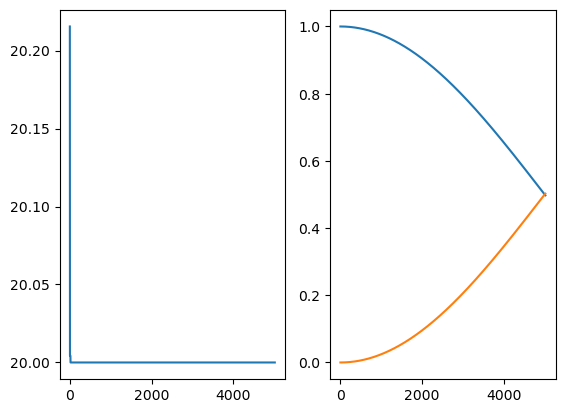

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from optimization.swarmintelligence.particleswarm import ParticleSwarmSystem, Dimension

def easy_bounds(bound):
    return (-bound, bound, -bound, bound)

def check_dim(dim, min = 1):
    assert (type(dim) == int and dim >=min), f"Dimension should be int and not less than {min} for this function (got {dim})"

class Ackley:
    
    b = 100
    
    def __init__(self, dim):
        
        check_dim(dim, 1)
        
        self.x_best = np.zeros(dim)
        self.f_best = 0
        
        self.bounds = easy_bounds(Ackley.b)
        
        self.bias = 20 + math.e
        self.pi2 = 2 * math.pi
    
    def __call__(self, vec):
        
        s1 = sum((x*x for x in vec))/vec.size
        s2 = sum((math.cos(self.pi2 * x) for x in vec))/vec.size
        
        return self.bias - 20*math.exp(-0.2*s1) - math.exp(s2)

## Need to be able to maximise or minimise.
a = Ackley(2)
psystem = ParticleSwarmSystem([Dimension(0.0, 100.0, 5.0), Dimension(0.0, 100.0, 5.0)], a, maximise=False)

result, data = psystem.run(total_particles=16,
                           init_strategy="random",
                           iterations_limit=10000,
                           stagnation_limit=0.5,
                           coef_decay_rate=1.0,
                           coef_decay_type="sin",
                           gather_stats=True,
                           bounce=False,
                           parallelise=False)

print(data)

fig, (fitness_axes, coefficient_axes) = plt.subplots(1, 2)
fitness_axes.plot(data["iteration"], data["global_best_fitness"])
coefficient_axes.plot(data["iteration"], data["personal_coef"])
coefficient_axes.plot(data["iteration"], data["global_coef"])
plt.show()

## Inverted Pendulum System

In [ ]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=10, processes=True, threads_per_worker=2)
client = Client(cluster)

Best position :: [19.64344466  1.14483311  3.98069056]


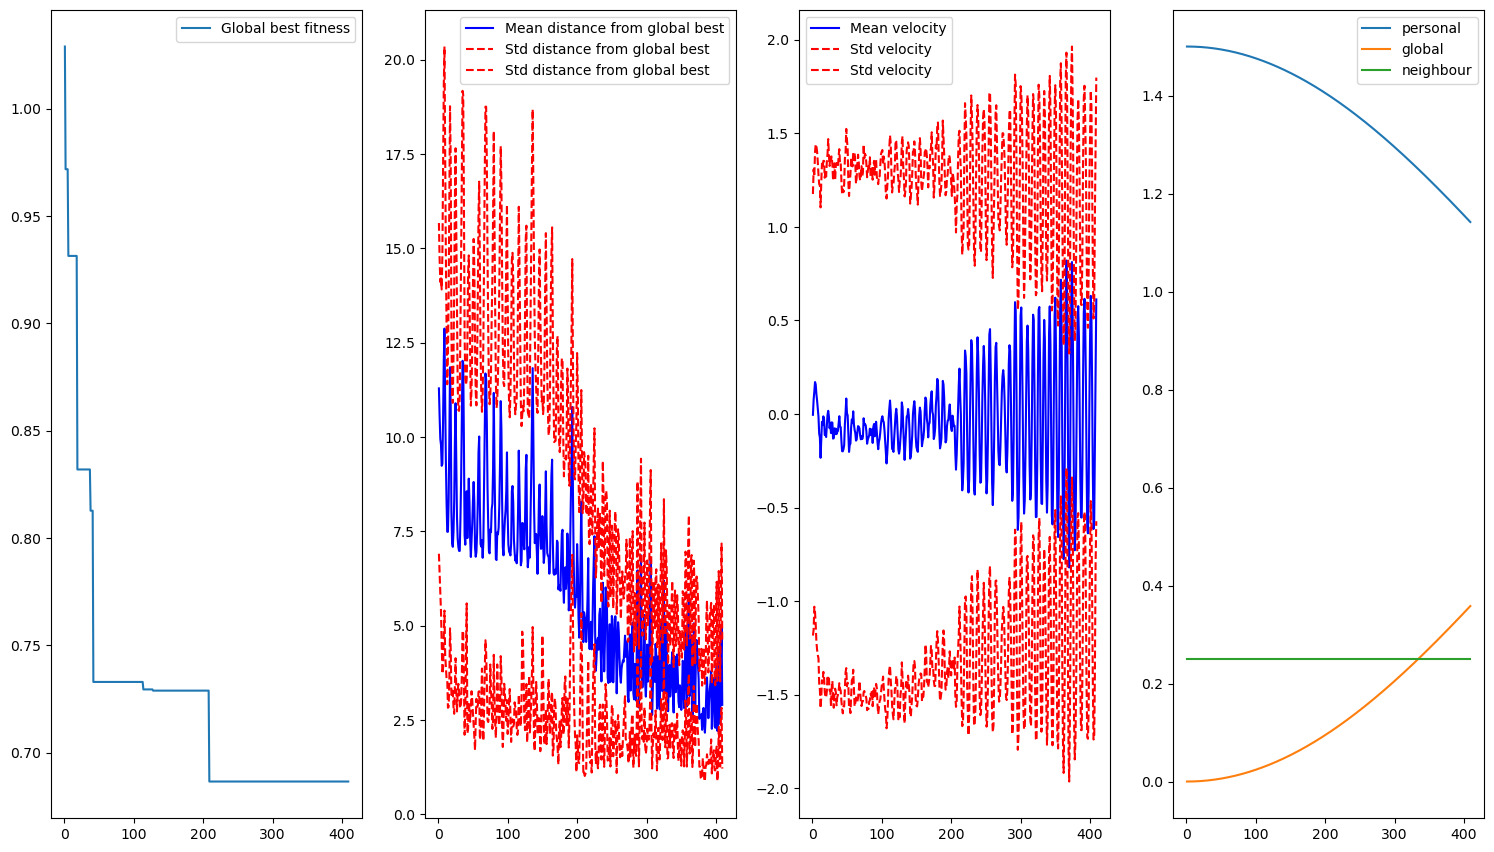

In [3]:
import matplotlib.pyplot as plt

from optimization.swarmintelligence.particleswarm import ParticleSwarmSystem, Dimension
from control.pid import PIDController
from control.systems import InvertedPendulumSystem
from control.controlutils import simulate_control

pend_system = InvertedPendulumSystem()
controller = PIDController(0.0, 0.0, 0.0, initial_error=pend_system.get_control_input() - pend_system.get_setpoint())

ticks: int = 100
delta_time: float = 0.1

def control_evaluator(vec):
    controller.reset()
    controller.set_gains(*vec)
    pend_system.reset()
    return simulate_control(pend_system, controller, ticks, delta_time)

psystem = ParticleSwarmSystem([Dimension(0.0, 25.0, 2.5),
                               Dimension(0.0, 5.0, 0.5),
                               Dimension(0.0, 10.0, 1.0)],
                              control_evaluator,
                              maximise=False)

result, data = psystem.run(total_particles=100,
                           init_strategy="linspace",
                           iterations_limit=1000,
                           stagnation_limit=0.20,
                           inertia=1.5,
                           final_inertia=0.5,
                           inertia_decay_rate=1.0,
                           inertia_decay_type="lin",
                           personal_coef=1.5,
                           personal_coef_final=0.5,
                           global_coef=0.0,
                           global_coef_final=1.0,
                           use_neighbourhood=False,
                           neighbour_method="kd_tree",
                           coef_decay_rate=1.0,
                           coef_decay_type="sin",
                           bounce=True,
                           use_fitness_approximation=False,
                           fitness_approximation_method="knr",
                        #    parallelise=True,
                        #    threads=20,
                           gather_stats=True)

print(f"Best position :: {result.best_position}")

fig, (fitness_axes, position_axes, velocity_axes, coefficient_axes) = plt.subplots(1, 4)
fitness_axes.plot(data["iteration"], data["global_best_fitness"], label="Global best fitness")
# fitness_axes.plot(data["iteration"], data["mean_best_particles_fitness"], label="Mean best particles fitness")
# fitness_axes.plot(data["iteration"], data["std_particles_fitness"], label="Std current particles fitness")
fitness_axes.legend()
position_axes.plot(data["iteration"], data["mean_distance_from_global_best"], "b", label="Mean distance from global best")
position_axes.plot(data["iteration"], data["mean_distance_from_global_best"] + data["std_distance_from_global_best"], "r--", label="Std distance from global best")
position_axes.plot(data["iteration"], data["mean_distance_from_global_best"] - data["std_distance_from_global_best"], "r--", label="Std distance from global best")
position_axes.legend()
velocity_axes.plot(data["iteration"], data["mean_velocity"], "b", label="Mean velocity")
velocity_axes.plot(data["iteration"], data["mean_velocity"] + data["std_velocity"], "r--", label="Std velocity")
velocity_axes.plot(data["iteration"], data["mean_velocity"] - data["std_velocity"], "r--", label="Std velocity")
velocity_axes.legend()
coefficient_axes.plot(data["iteration"], data["personal_coef"], label="personal")
coefficient_axes.plot(data["iteration"], data["global_coef"], label="global")
coefficient_axes.plot(data["iteration"], data["neighbour_coef"], label="neighbour")
coefficient_axes.legend()
fig.set_size_inches(18.5, 10.5)
fig.subplots_adjust(hspace=2.0)
plt.show()


Error curve turning points: [2.6]


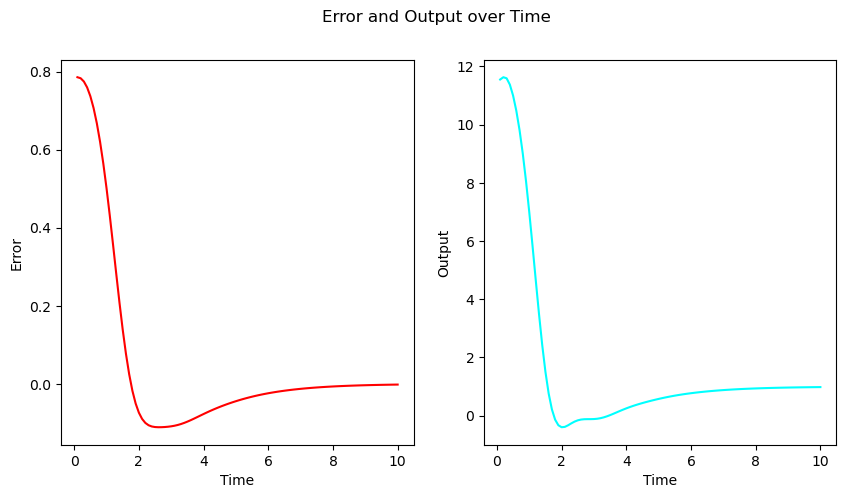

In [18]:
import numpy as np

from control.pid import PIDController
from control.systems import InvertedPendulumSystem
from control.controlutils import plot_error
from auxiliary.numpyutils import get_turning_points

pend_system = InvertedPendulumSystem()
controller = PIDController(*result.best_position, initial_error=pend_system.get_control_input() - pend_system.get_setpoint())

ticks: int = 100
delta_time: float = 0.1

time_points = np.full(ticks, delta_time).cumsum()
error_values = np.empty(ticks)
output_values = np.empty(ticks)

for tick in range(ticks):
    control_input = pend_system.get_control_input()
    setpoint = pend_system.get_setpoint()
    control_output = controller.control_output(control_input, setpoint, delta_time, abs_tol=None)
    pend_system.set_control_output(control_output, delta_time)
    error_values[tick] = controller.latest_error
    output_values[tick] = control_output
controller.reset()

print(f"Error curve turning points: {time_points[get_turning_points(error_values)]}")

plot_error(time_points, error_values, output_values)

## Mass Spring Damper System

In [5]:
import matplotlib.pyplot as plt

from optimization.swarmintelligence.particleswarm import ParticleSwarmSystem, Dimension
from control.pid import PIDController
from control.systems import MassSpringDamperSystem
from control.controlutils import simulate_control

msd_system = MassSpringDamperSystem(spring_constant=2.0, damping_constant=0.5, steady_state_error=1.5)
msd_system.random_start(seed=1)
controller = PIDController(0.0, 0.0, 0.0, initial_error=msd_system.get_control_input() - msd_system.get_setpoint())

ticks: int = 1000
delta_time: float = 0.1

def control_evaluator(vec):
    controller.reset()
    controller.set_gains(*vec)
    msd_system.reset()
    return simulate_control(msd_system, controller, ticks, delta_time)

psystem = ParticleSwarmSystem([Dimension(0.0, 2.0, 0.2),
                               Dimension(-1.0, 1.0, 0.1),
                               Dimension(-1.0, 1.0, 0.1)],
                               control_evaluator,
                               maximise=False)

result, data = psystem.run(
    total_particles=50,
    init_strategy="linspace",
    iterations_limit=10000,
    stagnation_limit=100,
    inertia=1.5,
    final_inertia=0.5,
    inertia_decay_rate=1.0,
    inertia_decay_type="lin",
    personal_coef=1.5,
    personal_coef_final=0.5,
    global_coef=0.0,
    global_coef_final=1.0,
    use_neighbourhood=False,
    neighbour_method="kd_tree",
    coef_decay_rate=1.0,
    coef_decay_type="sin",
    bounce=False,
    use_fitness_approximation=False,
    fitness_approximation_method="knr",
    gather_stats=True
)

print(f"Best position :: {result.best_position}")


Best position :: [ 1.62717637 -0.24442373 -1.1       ]


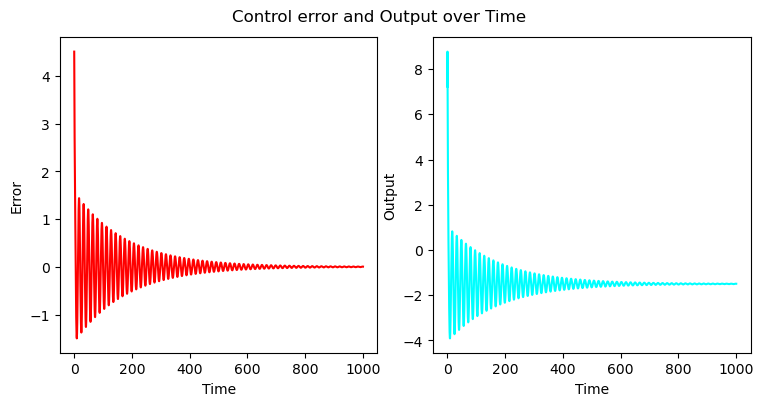

In [7]:
import numpy as np
from control.pid import PIDController
from control.systems import MassSpringDamperSystem
from control.controlutils import plot_error

msd_system = MassSpringDamperSystem(spring_constant=2.0, damping_constant=0.5, steady_state_error=1.5)
msd_system.random_start(seed=1)
controller = PIDController(*result.best_position)

ticks: int = 10000
delta_time: float = 0.1

time_points = np.full(ticks, delta_time).cumsum()
error_values = np.empty(ticks)
output_values = np.empty(ticks)

for tick in range(ticks):
    input = msd_system.get_control_input()
    setpoint = msd_system.get_setpoint()
    output = controller.control_output(input, setpoint, delta_time, abs_tol=None)
    msd_system.set_control_output(output, delta_time)
    error_values[tick] = input - setpoint
    output_values[tick] = output

plot_error(time_points, error_values, output_values)